In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import libs.AudioDataSet
import libs.AudioHash as hash
import libs.AudioFingerprint as fingerprint
import torchaudio.transforms as transforms
import torch
import matplotlib.pyplot as plt

In [3]:
import librosa
import numpy as np
import hashlib
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)

In [4]:
dataSet = libs.AudioDataSet.AudioDataset("../data/compressed_index/")

In [5]:
audio = dataSet[0]

In [6]:
audio_slice = np.zeros((1, 200000))
audio_slice[0] = audio[0,50000:250000]

In [7]:
from moviepy.audio.AudioClip import AudioArrayClip
audio1 = AudioArrayClip(audio.T, fps=10240*2)
audio2 = AudioArrayClip(audio_slice.T, fps=10240*2)

audio1.write_audiofile('test_1.wav')
audio2.write_audiofile('test_2.wav')

MoviePy - Writing audio in test_1.wav


MoviePy - Done.
MoviePy - Writing audio in test_2.wav


MoviePy - Done.


In [78]:
def compute_constellation_map(Y, dist_freq=7, thresh=0.01):
    struct = generate_binary_structure(2, 1)
    neighbors = iterate_structure(struct, dist_freq)
    
    local_max = maximum_filter(Y, footprint=neighbors) == Y
    background = (Y == 0)
    eroded_background = binary_erosion(background, structure=neighbors, border_value=1)
    
    Cmap = local_max ^ eroded_background
    # Cmap = Cmap * (Y.numpy() > thresh)
    return Cmap
  
def get_spectrogram(Y, n_fft = 512, hop_length = 512):
  spectrogram = transforms.Spectrogram(
    n_fft=n_fft,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
  )(torch.from_numpy(Y))
  print(spectrogram.min())
  if(spectrogram.min()<0):
      spectrogram = spectrogram - spectrogram.min()
  return spectrogram

def get_peaks(peaks):
  peaks = peaks.astype(int)
  peaks = np.transpose(np.nonzero(peaks.T))
  return peaks

In [79]:
def shazam_hash(peaks, fan_value = 15 ):
  IDX_FREQ_I = 0
  IDX_TIME_J = 1
  FINGERPRINT_REDUCTION = 20
  # для каждого пика
  for i in range(peaks.shape[0]):
    for j in range(1,fan_value):
      if i+j < peaks.shape[0]:
        # получим текущее и следующее пиковое значение частоты
        freq1 = peaks[i][IDX_FREQ_I]
        freq2 = peaks[i + j][IDX_FREQ_I]

        # получим текущее и следующее смещение времени пика
        t1 = peaks[i][IDX_TIME_J]
        t2 = peaks[i + j][IDX_TIME_J]

        # получим разницу по времени
        t_delta = t2 - t1

        # если разница между минимум и максимом считаем хэш
        if t_delta >= 0 and t_delta <= 100:
          seq = str(freq1)+"|"+str(freq2)+"|"+str(t_delta)
          h = hashlib.sha1(seq.encode('utf-8'))
          # обрезаем хэш
          yield (h.hexdigest()[0:FINGERPRINT_REDUCTION], t1)

In [80]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [81]:
def plot(spec,peaks):
  fig, axs = plt.subplots(1, 1)
  axs.set_title("Spectrogram (db)")
  axs.set_ylabel("fq")
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")
  axs.scatter(peaks[:,0], peaks[:, 1],s=1, color='red')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [82]:
def fingerprint(samples,fanset = 55):
  spec = get_spectrogram(samples,1024,1024)
  peaks_map = compute_constellation_map(spec[0],15,35)
  peaks = get_peaks(peaks_map)
  print(peaks_map.max())
  plot_spectrogram(spec[0])
  # return shazam_hash(peaks, fanset)


In [83]:
def shazam_compare(hashes1, hashes2):
    candidates = set(hashes1) & set(hashes2)
    print(candidates)
    return len(candidates)

tensor(7.7266e-16, dtype=torch.float64)
False


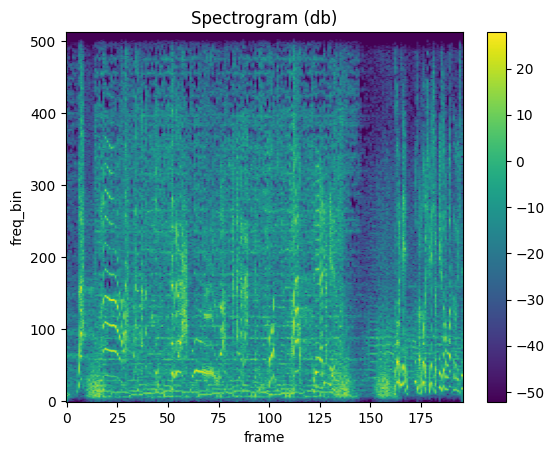

In [84]:
# f1 = fingerprint(audio)
f2 = fingerprint(audio_slice)


In [77]:
map1 = {}
for hash, t in f1:
  map1[hash] = t

map2 = {}
for hash, t in f2:
  map2[hash] = t

TypeError: 'NoneType' object is not iterable

In [ ]:
for key, value in map1.items():
  if key in map2:
    print(key, value, map2[key])

In [ ]:
print(matches)

NameError: name 'matches' is not defined